<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 5</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations

2025-06-24 15:21:06.330137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 15:21:06.364258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 15:21:06.464016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750771266.612706   77915 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750771266.651204   77915 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750771266.760777   77915 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - Ottimizzazione Bayesana</h1>

L’ottimizzazione bayesiana è una tecnica di ottimizzazione usata per trovare il massimo (o minimo) di una funzione obiettivo costosa da valutare e senza una forma analitica nota, cioè una black-box function.

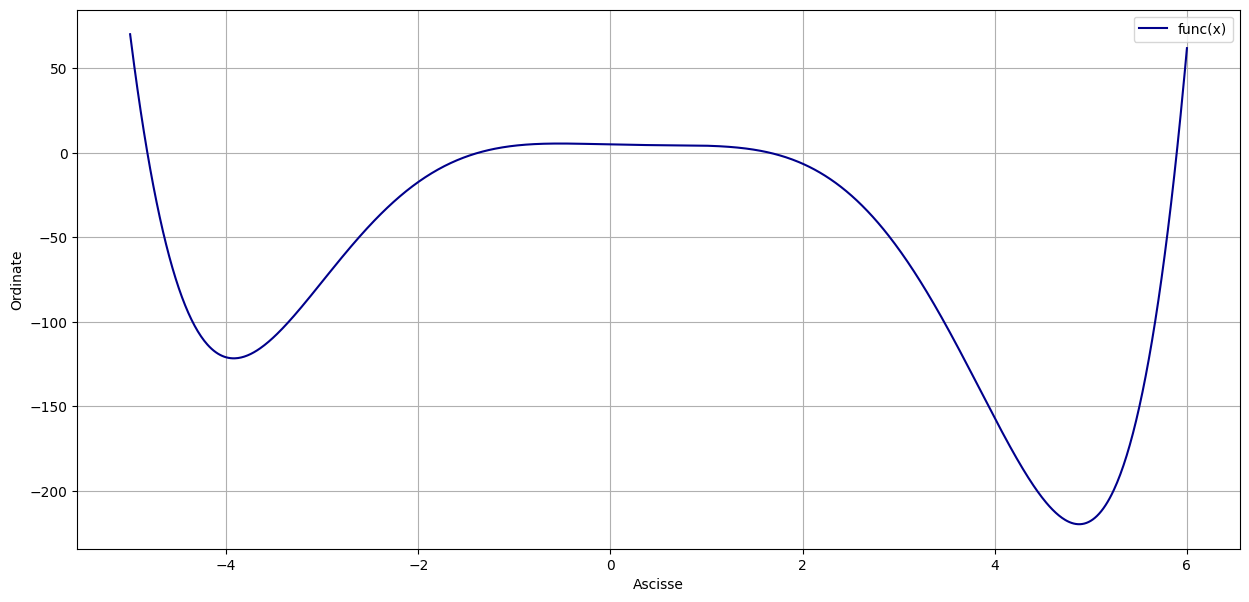

In [3]:
# Definisco funzione polinomiale f(x) = 0.05 * (x^6 - 2x^5 - 28x^4 + 28x^3 + 12x^2 - 26x + 100)
# Valuto tale funzione su un intervallo di punti equispaziati fra [-5, 6]
def func(x):
    p = np.poly1d([1, -2, -28, 28, 12, -26, 100])
    return p(x) * 0.05

def plotF(x):
    # Funzione per plottare target
    fig = plt.figure(figsize = (15, 7))
    plt.plot(x, func(x), color = 'darkblue', label = "func(x)")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

x = np.linspace(-5, 6, 1000)
plotF(x)